In [1]:
import pandas as pd
import pyddi

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
xnatsubs = pd.read_csv('/Users/freyta/Documents/Work/APGEM/data/exportado/ddi_plus_xnat_subs.csv')
data = pyddi.read_dump(cohort='ddi_plus', postprocess=False, printfile=True)
data = data.query('included == True')
data.loc[data['stag_text'] == 'NN', 'stag_text'] = 'MCI'


Reading dump file: /Users/freyta/Documents/Work/APGEM/data/exportado/ddi_plus_clinical_250401.csv


In [3]:
xnatsubs[~xnatsubs['label'].isin(data['subject_label'])]

,label,experiment_count,included,status,_group,subj_group_text
0,D13097,0,False,NaN,DDI,NaN
1,D13092,0,True,withdraw,DDI,NaN
2,D13096,0,True,active,DDI,NaN
3,D13098,0,True,active,DDI,NaN
4,D13095,1,True,active,DDI,Neuropsychiatric symptoms group
15,D13001,8,False,NaN,DDI,Cognitive symptom group


In [4]:
data['site'] = data['subject_label'].map(pyddi.site_from_subject_label)
data.site.value_counts()

site
Ahus    136
Name: count, dtype: int64

I think we could look at 
- baseline sociodemographics (a table 1), 
- then explore clinical and biological variables, e.g. correlate 1) gds/madrs vs neuropsychology, 2) gds/madrs vs csf (which ones?), 3) gds/madrs vs mri (which ones?) - we could for instance see if higher baseline depression load is associated with worse cognitive performance and more organic pathology over time. 
- explore social variables as well: age of retirement, marital status, educational level. What do you think?

In [5]:
total_subs = data['subject_label'].nunique()
total_observations = len(data)
gender_count = data.gender.value_counts()
total_subs
included_followups = data[(data['visit_id'] > 1) & (data['visit_id'].isin([1, 2, 3, 4, 5, 6]))]
mean_years_followup, sd_years_followup = included_followups.years_from_baseline.mean(), included_followups.years_from_baseline.std()
print('Icnluded subjects:', total_subs)
print('Total observations:', total_observations)
print(data.visit_id.value_counts())
print(f'Mean followup years: {mean_years_followup} ({sd_years_followup})')
print('Sum of followup years',included_followups['years_from_baseline'].sum())
print('Total mean followup years (N_subjects * mean_years)',mean_years_followup * total_subs)

Icnluded subjects: 90
Total observations: 136
visit_id
1      90
2      34
3      10
4       1
101     1
Name: count, dtype: int64
Mean followup years: 3.441353991662001 (1.6919026606947538)
Sum of followup years 151.41957563312803
Total mean followup years (N_subjects * mean_years) 309.72185924958006


In [6]:
pd.crosstab(data['stag_text'], data['a'])

a,0.0,1.0
stag_text,,
CN,9,0
Dementia,0,3
MCI,26,35
SCD,9,8


I see 96 D12/D13 existing subjects in XNAT. 5 of them don't have any experiment, of which one is not included in the study and another withdrew. 

As of this morning, this is the available data:
Icnluded subjects: 90
Total observations: 136
Follow-ups:
1:      90
2:     34
3:      10
4:       1

Mean followup years: 3.44 (1.69)
Sum of followup years 151.41

Regarding staging and amyloid status:
         -       +
CN       9       0
SCD      9       8
MCI      26      35
Dementia 0       3

CN is Cognitively Normal



In [7]:
data[['subject_label', 'ugot_p217_plasma_mean','ugot_p217_csf_mean']]
data['ugot_p217_plasma_mean'].notna().sum(), data['ugot_p217_csf_mean'].notna().sum()


(np.int64(98), np.int64(56))

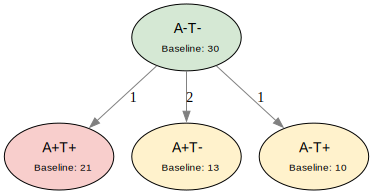

In [8]:
pyddi.plot_at_progression_graph(data)

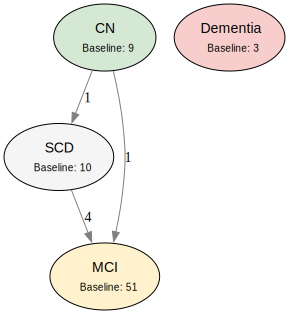

In [9]:
pyddi.plot_stage_progression_graph(data, stage_col='stag')

In [10]:
mean_edu_years = data['edu_years'].mean()
edu_years_sd = data['edu_years'].std()
total_subs = data['subject_label'].nunique()

print(f"N: {total_subs}")
print(f"Mean education years: {mean_edu_years:.2f} ({edu_years_sd:.2f})")
print()

baseline = data.query('visit_id == 1')
first_followup = data.query('visit_id == 2')

def print_baseline_stats(df):

    total_subs = df['subject_label'].nunique()
    
    n_male = df.query('gender == "male"').shape[0]
    n_female = df.query('gender == "female"').shape[0]
    percentage_male = n_male / total_subs
    mean_age = df['mh_age'].mean()
    sd_age = df['mh_age'].std()
    mean_mmse = df['mmse_total'].mean()
    sd_mmse = df['mmse_total'].std()
    mean_gds = df['gds_15_total'].mean()
    sd_gds = df['gds_15_total'].std()
    mean_madrs = df['madrs_score'].mean()
    sd_madrs = df['madrs_score'].std()
    
    print(f"N: {total_subs} ({percentage_male:.2%})")
    print(f"Mean age: {mean_age:.2f} ({sd_age:.2f})")
    print(f"Mean MMSE: {mean_mmse:.2f} ({sd_mmse:.2f})")
    print(f"Mean GDS: {mean_gds:.2f} ({sd_gds:.2f})")
    print(f"Mean MADRS: {mean_madrs:.2f} ({sd_madrs:.2f})")

# Example usage
print_baseline_stats(baseline)
print()
print_baseline_stats(first_followup)


N: 90
Mean education years: 12.34 (2.99)

N: 90 (34.44%)
Mean age: 73.08 (5.92)
Mean MMSE: 27.26 (2.91)
Mean GDS: 4.89 (3.96)
Mean MADRS: 11.71 (7.06)

N: 34 (44.12%)
Mean age: 75.03 (6.11)
Mean MMSE: 26.30 (4.09)
Mean GDS: 4.90 (3.78)
Mean MADRS: 9.50 (5.85)


## Data availability

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_theme(style="whitegrid", palette="husl")

def plot_countplot(
        data, 
        variable, 
        hue=None, 
        title='',
        annotate=True,
        show_percentage=True,
        xlabel='',
        ylabel='',
        figsize=(12,
        8),
        ax=None,
        order=True,
        color=None):
    if ax is None:
        plt.figure(figsize=figsize)
        if order:
            ax = sns.countplot(y=variable, data=data, hue=hue, order=data[variable].value_counts().index, color=color if hue is None else None)
        else:
            ax = sns.countplot(y=variable, data=data, hue=hue, color=color if hue is None else None)
    else:
        if order:
            sns.countplot(y=variable, data=data, hue=hue, order=data[variable].value_counts().index, ax=ax, color=color if hue is None else None)
        else:
            sns.countplot(y=variable, data=data, hue=hue, ax=ax, color=color if hue is None else None)
        
    sns.despine()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if annotate:
        for p in ax.patches:
            count = p.get_width()
            if show_percentage:
                percentage = 100 * count / len(data)
                if count > 0:
                    text = f'{int(count)} ({percentage:.2f}%)'
                    ax.text(count + 0.6, p.get_y() + p.get_height() / 2., text, va="center")
            else:
                if count > 0:
                    text = f'{int(count)}'
                    ax.text(count + 0.6, p.get_y() + p.get_height() / 2., text, va="center")
    if ax is None:
        plt.show()

    return ax

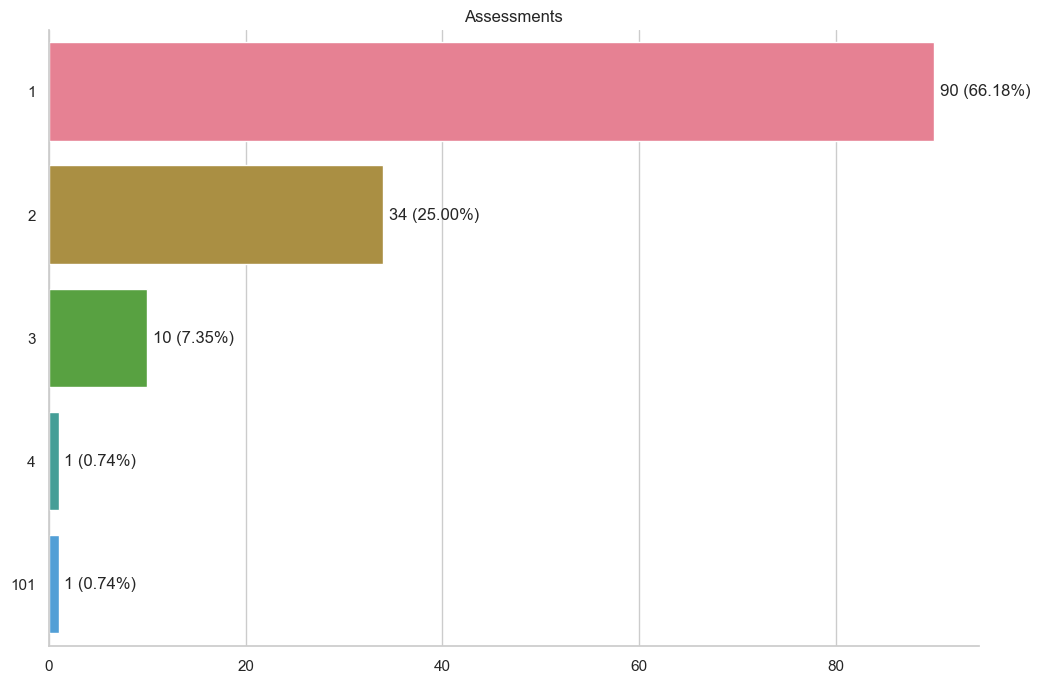

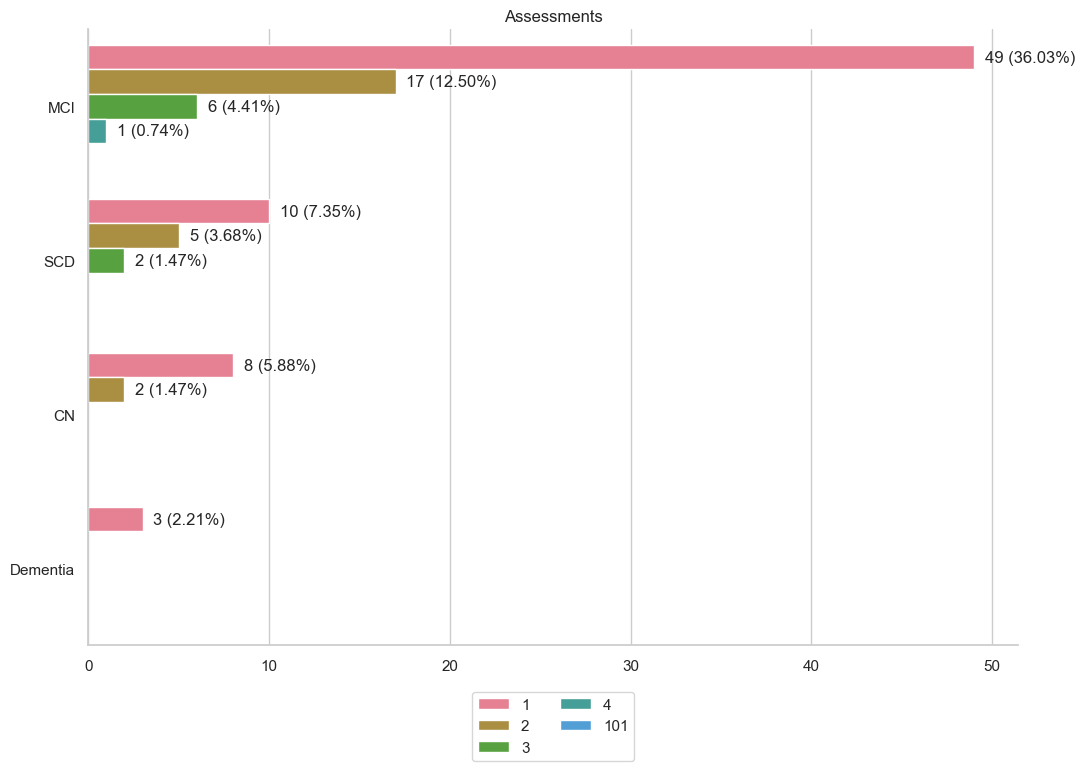

In [12]:
plot_countplot(
    data,
    variable='visit_id',
    title='Assessments',
    
)

ax = plot_countplot(
    data,
    variable='stag_text',
    hue='visit_id',
    title='Assessments',
    
)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)

Text(0, 0.5, '')

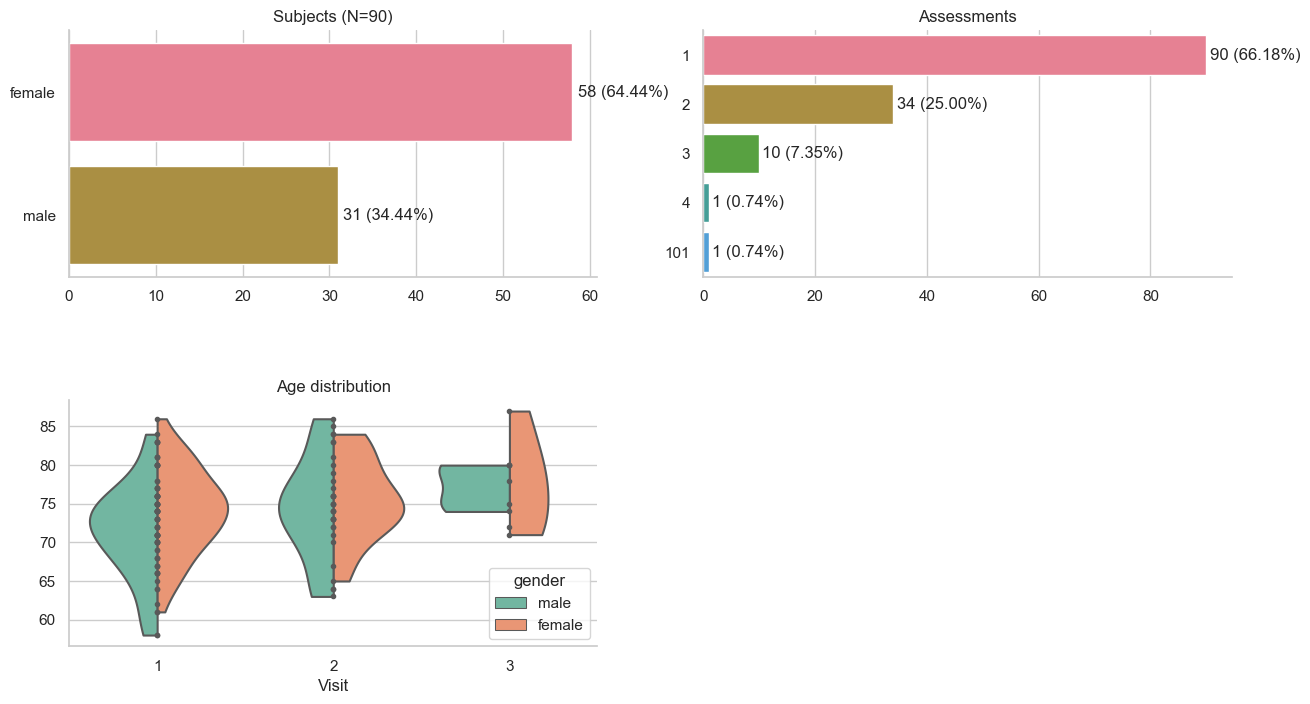

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.subplots_adjust(hspace=0.5)  # Increase the gap between rows
axes[1][1].axis('off')  # Deactivate the axes[1][1]
pyddi.plot_countplot(
    baseline,
    variable='gender',
    title=f'Subjects (N={len(baseline)})',
    ax=axes[0][0],
)

pyddi.plot_countplot(
    data,
    variable='visit_id',
    title='Assessments',
    ax=axes[0][1],
)

vilax = axes[1][0]
sns.violinplot(
    data=data[data['visit_id'] < 4], 
    x="visit_id", 
    y="available_age",
    cut=0, 
    split=True, 
    inner="point", 
    ax=vilax, 
    hue='gender', 
    palette="Set2", 
    dodge=True,
    )
vilax.set_title('Age distribution')
vilax.set_xlabel('Visit')
vilax.set_ylabel('')


In [25]:
data[data['visit_id'] < 4].available_age.min()

np.float64(58.0)

In [13]:
label_cols = [col for col in data.columns if 'label' in col]
label_cols

['subject_label',
 'subject_label_full',
 'mh_label',
 'cs_label',
 'diag_label',
 'csf_label',
 'bioch_label',
 'phyex_label',
 'madrs_label',
 'dat_label',
 'petct_label']

AttributeError: 'DataFrame' object has no attribute 'iteritems'

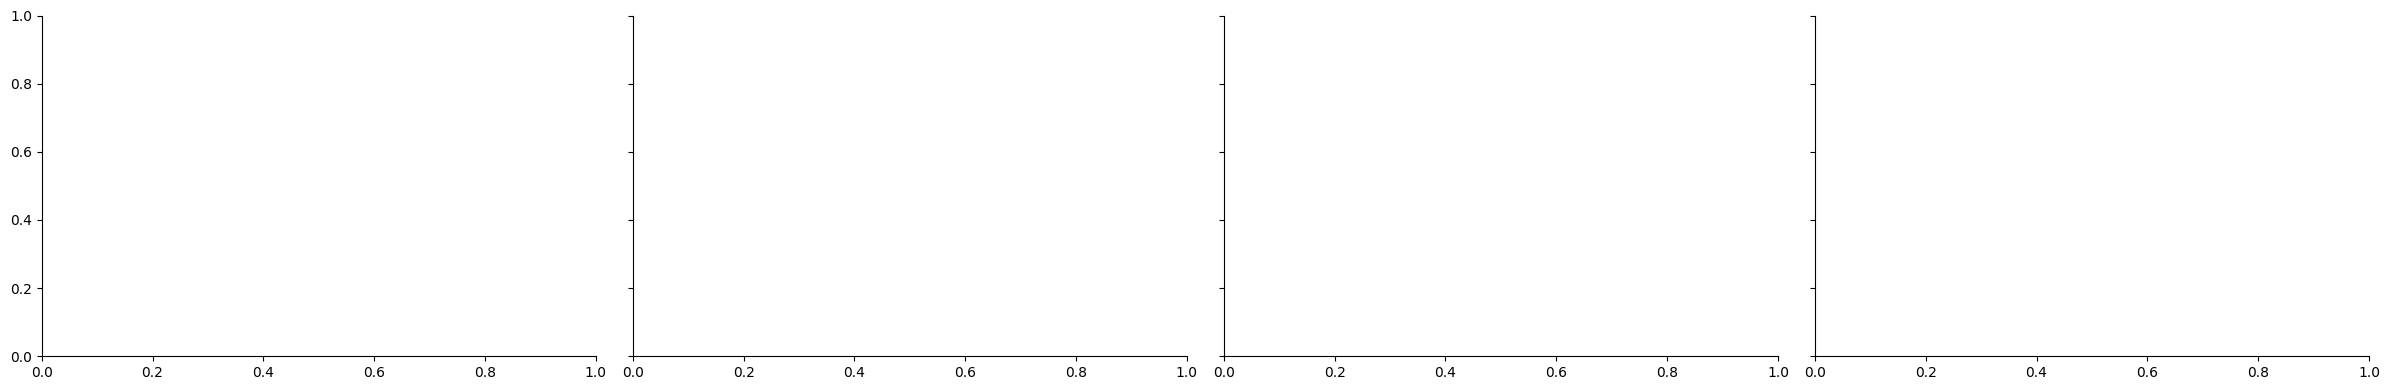

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
# mci = data.query('stag_text == "MCI"')
# print(len(mci), mci['gds_15_total'].notna().sum(),mci['gds_15_total'].isna().sum())

g = sns.FacetGrid(
    data,
    col='progression_type',
    palette='husl',
    height=4,
    aspect=1.5
)

g.map(
    sns.lineplot, 
    'years_from_baseline', 
    'gds_15_total', 
    # estimator=None, 
    # lw=1, 
    alpha=0.7, 
    units='subject_label'
    )

# sns.lineplot(
#     data=mc,
#     x='years_from_baseline',
#     y='gds_15_total',
#     estimator=None,
#     units='subject_label',
#     lw=1,
#     alpha=0.7,
#     # ax=axes[0]
# )

# sns.scatterplot(
#     data=mci,
#     x='years_from_baseline',
#     y='gds_15_total',
#     # ax=axes[0]
# )

In [24]:
# mci.query('years_from_baseline > 0')[['subject_label', 'visit_id', 'years_from_baseline','mh_label', 'gds_15_total']]
data.progression_type.value_counts()

progression_type
Stable MCI               67
Stable CN                36
CN to MCI                16
Stable non progressor     7
Name: count, dtype: int64

In [23]:
mci.query('subject_label == "D13023"')[['subject_label', 'visit_id', 'years_from_baseline','mh_label', 'gds_15_total']]

,subject_label,visit_id,years_from_baseline,mh_label,gds_15_total
43,D13023,3,7.030801,D13023_mh_20250130_3,3.0
